# Experiment 4: Generalization

__Objective:__ Assess the model's ability to generalize by evaluating its captioning performance on an out-of-domain dataset (e.g., Flickr30k) without additional fine-tuning. Performance will be measured using standard metrics (BLEU, METEOR, etc.) to determine how well the model transfers to visually and semantically diverse content beyond the training distribution.

__Research Question(s):__ How accurately do image captioning models preserve the semantic content of an input image?

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from vtt.data.caption_preprocessing import load_tokenizer, load_and_clean_captions
from vtt.data.data_loader import load_full_dataset
from vtt.models.decoder import build_decoder_model
from vtt.models.predict import display_images_with_greedy_captions, display_images_with_beam_captions
from vtt.evaluation.evaluate import evaluate_model_greedy, evaluate_model_beam

/opt/miniconda3/envs/genai_project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Paths

In [3]:
dataset_name = "flickr30k"
features_path = f"../../data/processed/{dataset_name}_features.npz"
captions_path = f"../../data/processed/{dataset_name}_padded_caption_sequences.npz"
tokenizer_path = f"../../data/processed/{dataset_name}_tokenizer.json"
captions_file = f"../../data/raw/{dataset_name}_captions.csv"

## Load Tokenizer and Features

In [4]:
tokenizer = load_tokenizer(tokenizer_path)
features = np.load(features_path)

[INFO] Tokenizer loaded from JSON file: ../../data/processed/flickr30k_tokenizer.json


## Load out of domain dataset (Flickr30k)

In [5]:
generalization_dataset = load_full_dataset(
    features_path=features_path,
    captions_path=captions_path,
    shuffle=True,
    buffer_size=1000,
    seed=42,
    cache=True,
    return_numpy=False
)

## Fetch Max Caption Length and vocabulary size

In [6]:
# Get max caption length from dataset
for _, input_caption, _ in generalization_dataset.take(1):
    max_caption_len = input_caption.shape[1]
# Get vocab size
vocab_size = tokenizer.num_words


2025-07-28 10:18:21.282443: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-07-28 10:18:21.283123: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Load the saved Model Weights

In [7]:
model = build_decoder_model(vocab_size=vocab_size,
                            max_caption_len=max_caption_len)

checkpoint_path = "../../models/flickr8k_decoder_weights.weights.h5"
model.load_weights(checkpoint_path)
print("Loaded pretrained weights")


Loaded pretrained weights


/opt/miniconda3/envs/genai_project/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Evaluate Model on out of domain dataset (Flickr30k)

### Evaluate Scores using Greedy Caption Generation

In [24]:
references_dict = load_and_clean_captions(f"../data/raw/{dataset_name}_captions.csv")

scores_greedy = evaluate_model_greedy(
    model=model,
    tokenizer=tokenizer,
    features=features,
    test_dataset=generalization_dataset,
    references_dict=references_dict,
    max_len=max_caption_len,
)

Evaluating: 100%|██████████| 4926/4926 [17:57:10<00:00, 13.12s/it]
/opt/miniconda3/envs/genai_project/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
W0724 12:52:10.073000 94761 site-packages/torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### BLEU, METEOR and BertScore for Greedy Caption generation

In [ ]:
print("Evaluation Scores:")
for metric, score in scores_greedy.items():
    print(f"{metric}: {score:.4f}")

Evaluation Scores:
BLEU-1: 0.3769
BLEU-2: 0.1326
BLEU-3: 0.0618
BLEU-4: 0.0403
METEOR: 0.1624
BERTScore_P: 0.8267
BERTScore_R: 0.8210
BERTScore_F1: 0.8238


### Evaluate Scores for Test Dataset using Beam Search

In [26]:
scores_beam = evaluate_model_beam(
    model=model,
    tokenizer=tokenizer,
    features=features,
    test_dataset=generalization_dataset,
    references_dict=references_dict,
    max_len=max_caption_len,
    beam_width=5
)

Evaluating: 100%|██████████| 4926/4926 [84:12:04<00:00, 61.54s/it]   
/opt/miniconda3/envs/genai_project/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### BLEU, METEOR and BertScore for Beam Search

In [27]:
print("Evaluation Scores:")
for metric, score in scores_beam.items():
    print(f"{metric}: {score:.4f}")

Evaluation Scores:
BLEU-1: 0.3698
BLEU-2: 0.1256
BLEU-3: 0.0594
BLEU-4: 0.0402
METEOR: 0.1542
BERTScore_P: 0.8268
BERTScore_R: 0.8192
BERTScore_F1: 0.8229


## Predict Sample Captions for the out of domain dataset (Flickr30k)

In [23]:
import random

# Step 1: Unbatch and collect all image IDs from test_ds
all_image_ids = [img_id.numpy().decode('utf-8') for (_, _,),_, img_id in generalization_dataset.unbatch()]

# Step 2: Sample 5 random IDs
sample_image_ids = random.sample(all_image_ids, 5)


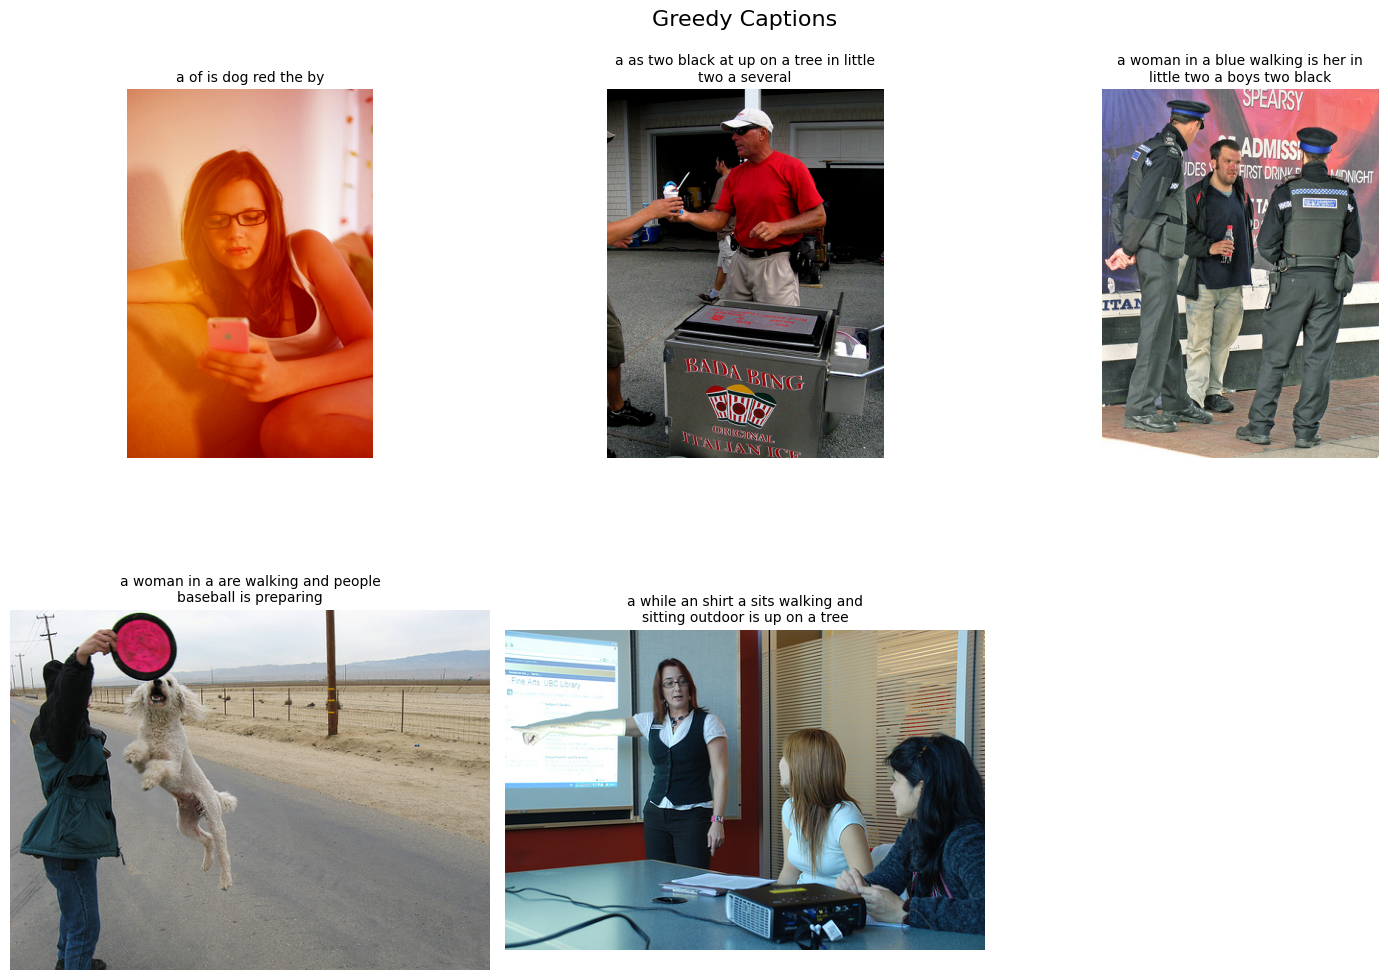

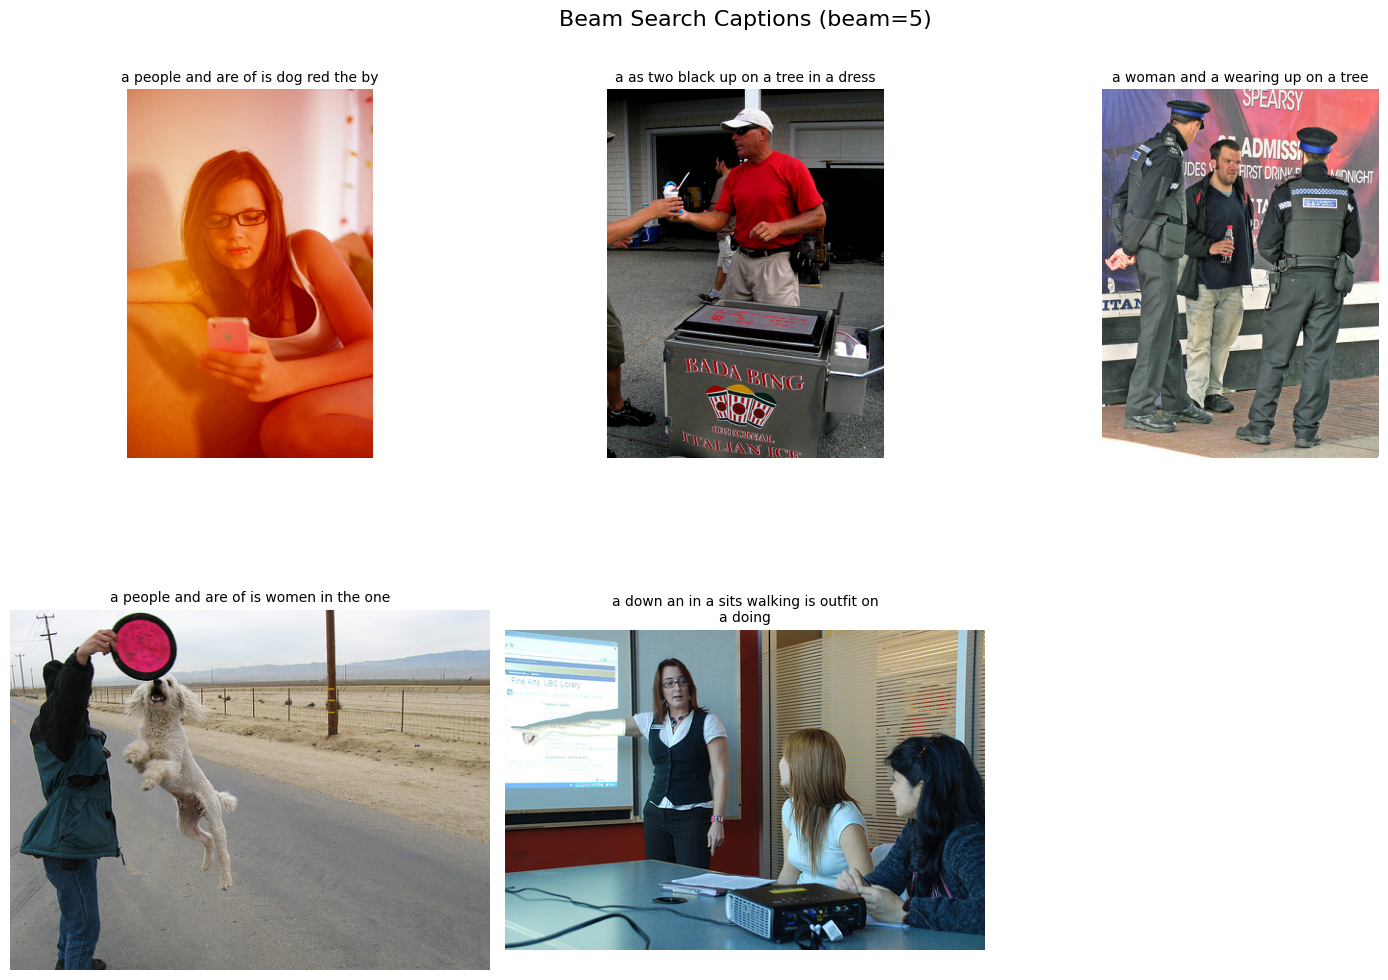

In [24]:
image_folder = "../../data/flickr30k_images_dataset/Images"


# Step 3: Call display_images_with_captions
display_images_with_greedy_captions(
    image_ids=sample_image_ids,
    model=model,
    tokenizer=tokenizer,
    features=features,
    image_folder=image_folder
)

display_images_with_beam_captions(
    image_ids=sample_image_ids,
    model=model,
    tokenizer=tokenizer,
    features=features,
    image_folder=image_folder,
    beam_width=5,
    max_len=max_caption_len,
    cols=3,
)
